In [1]:
omega_b = 0.0479; h = 0.6814
scale=0.1452
mean_nb = 1.123e-5/scale**3*omega_b*h**2

In [2]:
print(mean_nb)

8.158675857594528e-05


In [3]:
from scipy import integrate
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle

In [4]:
def unPackRawFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
   
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

def getPos(path_LOS,linenumber=8):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=8):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def calculate_gamma(temperature,density,xHI,scale):
    '''Gamma = R(T)*ne/xHI, R(T) = 4.3e-13 * (T/1e4K)^{-0.7), ne = 0.82*nb.
    '''
    omega_b = 0.0479; h = 0.6814
    mean_nb = 1.123e-5/scale**3*omega_b*h**2
    nb = np.multiply(density ,mean_nb); ne = 0.82*nb
    R_T = 4.3e-13 * (np.divide(temperature,1e4))**(-0.7)
    gamma = R_T * ne / xHI
    
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    neutral_fraction = []
    real_lyman = []
    gamma = []
    HI = []
    gas_den = []
    real_area_under = []
    temperature = []
    A = []
    which = 0
    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance_cm = distance *0.1453*3.086e24 /0.68
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                peak_gas = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        #getting the information about the top point of the peak
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                            peak_A = np.divide(gas_density[k],mean_nb)
                            peak_temp = temp[k]
                            peak_gas = gas_density[k]
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    real_distance = [(position[0]/256*40+peak_distance*direction[0])%40, (position[1]/256*40+peak_distance*direction[1])%40,(position[2]/256*40+peak_distance*direction[2])%40]
                    distance_graph = []
                    HI_graph = [ ]
                    distance_real = []
                    delta_b_plus_one = []
                    for i in range(len(distance)):
                    #calculating the culmulative integral over the peak.
                        if(distance[left_bases]<=distance[i]<= distance[right_bases]):
                            distance_graph.append(distance_cm[i])
                            HI_graph.append(HI_density[i])
                            delta_b_plus_one.append(np.divide(gas_density[i],mean_nb))
                            distance_real.append(distance[i])
                    y_int = integrate.cumtrapz(HI_graph,distance_graph,initial = 0)
                    #here we calculate delta_b_plus_one
                    #x_int = peak_A**2 * 
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(y_int[-1] >= (10**16)and y_int[-1]  <= (10**22)):
                        real_lyman.append([y_int,real_distance])
                        real_area_under.append(y_int[-1])
                        neutral_fraction.append(peak_fraction)
                        A.append(peak_A)
                        HI.append(peak_HI)
                        gas_den.append(peak_gas)
                        temperature.append(peak_temp)
                        which = [i,distance[left_bases], distance[right_bases], peak_distance]
    return real_lyman,neutral_fraction,HI,gas_den,which,real_area_under,A,temperature

In [22]:
def lyman_identification_test():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    neutral_fraction = []
    real_lyman = []
    gamma = []
    HI = []
    gas_den = []
    real_area_under = []
    temperature = []
    A = []
    distance_array = []
    delta_b_plus_one_array = []
    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance_cm = distance *0.1453*3.086e24 /0.68
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                peak_gas = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        #getting the information about the top point of the peak
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                            peak_A = np.divide(gas_density[k],mean_nb)
                            peak_temp = temp[k]
                            peak_gas = gas_density[k]
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    real_distance = [(position[0]/256*40+peak_distance*direction[0])%40, (position[1]/256*40+peak_distance*direction[1])%40,(position[2]/256*40+peak_distance*direction[2])%40]
                    distance_graph = []
                    HI_graph = [ ]
                    distance_real = []
                    delta_b_plus_one = []
                    for i in range(len(distance)):
                    #calculating the culmulative integral over the peak.
                        if(distance[left_bases]<=distance[i]<= distance[right_bases]):
                            distance_graph.append(distance_cm[i])
                            HI_graph.append(HI_density[i])
                            delta_b_plus_one.append(np.divide(gas_density[i],mean_nb))
                            distance_real.append(distance[i])
                    y_int = integrate.cumtrapz(HI_graph,distance_graph,initial = 0)
                    #here we calculate delta_b_plus_one
                    #x_int = peak_A**2 * 
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(y_int[-1] >= (10**17)and y_int[-1]  <= (10**22)):
                        real_lyman.append([y_int,real_distance])
                        real_area_under.append(y_int[-1])
                        neutral_fraction.append(peak_fraction)
                        A.append(peak_A)
                        HI.append(HI_graph)
                        gas_den.append(peak_gas)
                        temperature.append(peak_temp)
                        distance_array.append(distance_real)
                        delta_b_plus_one_array.append(delta_b_plus_one)
    return real_lyman,neutral_fraction,HI,gas_den,distance_array,real_area_under,A,temperature,delta_b_plus_one_array

In [23]:
import numpy as np
real_lyman,neutral_fraction,HI,gas_den,distance_array,real_area_under,peak_b_plus_one,temperature,delta_b_plus_one_test  = lyman_identification_test()


In [24]:
from scipy.interpolate import UnivariateSpline

def fit(peak_b_plus_one, delta_b_plus_one_test,distance_array):
    prediction_A = []
    #first convert the distance array to Mpc
    constant = 0.1453/0.68
    #going over all the lls
    for distance_temp,delta_b_temp,peak_delta_b_one_plus_temp in zip(distance_array,delta_b_plus_one_test,peak_b_plus_one):
        distance = np.multiply(distance_temp,constant)
        #finding the A of the equation
        delta_b_plus_one_logged = np.log(delta_b_temp)
        #smoothing the data
        y_spl = UnivariateSpline(distance, delta_b_plus_one_logged,s=20,k=3)
        y_spl_2d = y_spl.derivative(n=2)
        #finding the value of the integral
        test = integrate.cumtrapz(y_spl_2d(distance),distance,initial = 0)
        derivative_value = (-1*test[-1])**(-1/2)
        a_value = peak_delta_b_one_plus_temp**2 *derivative_value
        prediction_A.append(a_value)
    return prediction_A

def first_part(temeprature):
    value = []
    J_HI =2.281e-13/4e-12
    print(J_HI)
    constant = ((1+5.8823)/4)**5 * ((2/1.65)**(-0.5))*1.63e13*((0.0479*(0.6814**2))/0.0125)**2*(J_HI/0.5)**-1
    print(constant)
    first_part = np.power(np.divide(temperature,10**4),-0.7)*constant
    return first_part 

In [25]:
first_part_value = first_part(temperature)

0.057025000000000006
6196505625518625.0


In [26]:
second_part_value = fit(peak_b_plus_one,delta_b_plus_one_test,distance_array)

/tmp/ipykernel_20370/3266484575.py:17: RuntimeWarning: invalid value encountered in double_scalars
  derivative_value = (-1*test[-1])**(-1/2)


error: (m>k) failed for hidden m: fpcurf0:m=2

In [ ]:
total = first_part_value*second_part_value

In [19]:
total

array([5.93582011e+17, 3.64338049e+18, 9.12750268e+17, 2.93197426e+20,
       6.41835153e+17, 6.61889170e+18, 3.12318044e+17, 1.34136523e+18,
       9.42829576e+20, 6.62559899e+18, 3.16188166e+17, 7.93256994e+17,
       1.82578407e+18, 9.53319292e+16, 6.01307517e+17, 6.30559108e+17,
       1.04258767e+18, 5.89304398e+17, 1.18648918e+18, 2.07212735e+17,
       1.19810900e+18, 2.32826340e+17,            nan, 9.28682964e+17,
       3.18327555e+17, 2.77889283e+18, 5.19499039e+17, 1.42605286e+18,
       3.44666439e+17, 3.39856999e+18, 3.59299633e+17, 3.06418592e+17,
       2.35146384e+17, 9.30910742e+18, 2.60171707e+17, 3.94977612e+17,
       2.69402488e+18, 1.03242844e+18, 5.67526134e+17, 7.34971716e+18,
       5.42385951e+19, 1.47310874e+19, 2.90714193e+17, 6.45341916e+18,
       2.62061377e+17, 1.89815476e+18, 2.03809379e+18, 5.75499062e+18])

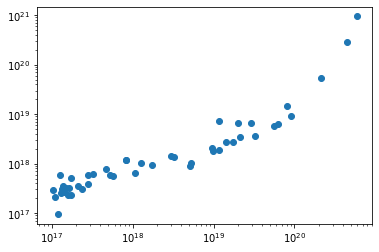

In [21]:
plt.scatter(real_area_under,total)
plt.xscale("log")
plt.yscale("log")

In [13]:
np.multiply(first_part,second_part)

NameError: name 'second_part' is not defined

In [ ]:
real_lyman

[[array([0.00000000e+00, 1.75658527e+16, 5.89606979e+16, 9.34927135e+16,
         1.62559514e+17, 2.53465696e+17, 3.35685528e+17, 4.12966281e+17,
         4.63229208e+17, 5.23607944e+17]),
  [30.984046649070947, 17.23378496008418, 26.768540471680083]],
 [array([0.00000000e+00, 3.81631448e+18, 1.30344749e+19, 2.06641273e+19,
         2.94150659e+19, 3.28483101e+19, 3.28606978e+19, 3.28709508e+19]),
  [31.023952697851072, 17.185680250341036, 26.77070744451929]]]

In [ ]:
constant = 0.1453/0.68

In [ ]:
temp_distance = np.multiply(which[-1],constant)

NameError: name 'which' is not defined

In [ ]:
which[-1]

[80.82494,
 80.82811,
 80.83194,
 80.83511,
 80.83894,
 80.84211,
 80.84594,
 80.84911]

Text(0, 0.5, 'HI density')

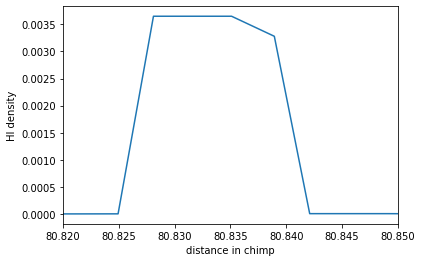

In [ ]:
raw_path = 'los.00' + '{0:03}'.format(0) +'.raw'
distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
plt.plot(distance,HI_density)
plt.xlim(80.82,80.85)
plt.xlabel("distance in chimp")
plt.ylabel("HI density")

In [ ]:
delta_b_plus_one_test = np.log(delta_b_plus_one_test[-1])

In [ ]:
delta_b_plus_one_test

array([3.05536511, 5.370002  , 5.370002  , 5.370002  , 5.22342855,
       3.22976469, 3.22976469, 3.22976469])

In [ ]:
temp_distance

array([17.27038791, 17.27106527, 17.27188365, 17.272561  , 17.27337939,
       17.27405674, 17.27487512, 17.27555248])

Text(0, 0.5, 'HI density from peak detection')

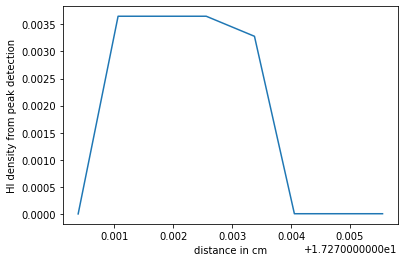

In [ ]:
plt.plot(temp_distance,HI[-1])
plt.xlabel("distance in cm")
plt.ylabel("HI density from peak detection")

Text(0, 0.5, 'logged delta b plus one')

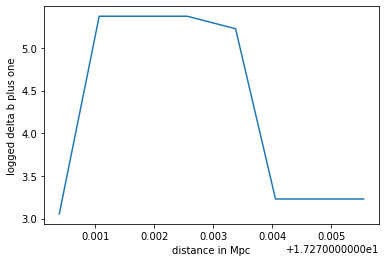

In [ ]:
plt.plot(temp_distance,delta_b_plus_one_test)
plt.xlabel("distance in Mpc")
plt.ylabel("logged delta b plus one")

In [ ]:
from scipy.interpolate import UnivariateSpline

y_spl = UnivariateSpline(temp_distance, delta_b_plus_one_test,s=200,k=4)
y_spl_2d = y_spl.derivative(n=2)

In [ ]:
delta_b_plus_one_test

array([3.05536511, 5.370002  , 5.370002  , 5.370002  , 5.22342855,
       3.22976469, 3.22976469, 3.22976469])

Text(0, 0.5, 'logged delta b plus one')

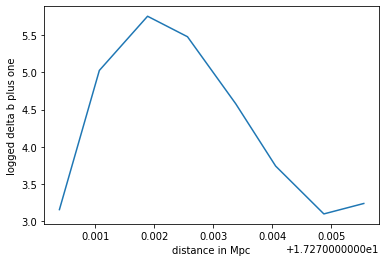

In [ ]:
plt.plot(temp_distance,y_spl(temp_distance))
plt.xlabel("distance in Mpc")
plt.ylabel("logged delta b plus one")

Text(0, 0.5, 'second order derivative of logged delta b plus one in Mpc distance')

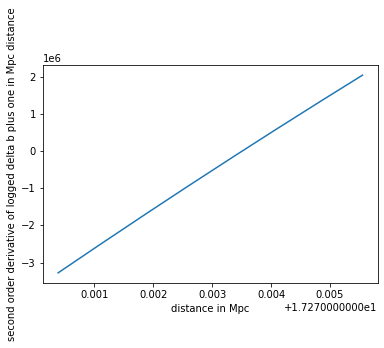

In [ ]:
plt.plot(temp_distance,y_spl_2d(temp_distance))
plt.xlabel("distance in Mpc")
plt.ylabel("second order derivative of logged delta b plus one in Mpc distance")

In [ ]:
test = integrate.cumtrapz(y_spl_2d(temp_distance),temp_distance,initial = 0)

In [ ]:
second_part = (-1*test[-1])**(-1/2)

In [ ]:
second_part

0.018361144583925213

In [ ]:
A[-1]

185.56932845796155

In [ ]:
a_value = A[-1]**2 *second_part

In [ ]:
#a_value should be very small
a_value 

632.2839280614551

In [ ]:
J_HI =2.281e-13/4e12

In [ ]:
temperature[-1]

11250.0

In [ ]:
N_HI = 2.0290289224774378*10**34*a_value

In [ ]:
(temperature[-1]/(10**4))**-0.7

0.9208592062264477

In [ ]:
((0.0479*(0.6814**2))/0.0125)**2

3.165625369558989

In [ ]:
(J_HI/0.5)**(-1)

3.1230480949406618e+19

In [ ]:
((1+5.8823)/4)**5

92.04288275474705

In [ ]:
(2/1.65)**(-0.5)

0.9082951062292475

In [ ]:
1.63e13*7.61112072975131e+21

1.2406126789494635e+35

In [ ]:
N_HI

1.282922377254336e+37

In [ ]:
HI

[[3.936e-07,
  1.652e-05,
  1.652e-05,
  1.652e-05,
  4.103e-05,
  4.103e-05,
  3.739e-05,
  2.397e-05,
  2.397e-05,
  2.397e-05],
 [1.424e-06,
  0.00365,
  0.00365,
  0.00365,
  0.00328,
  4.905e-06,
  4.905e-06,
  4.905e-06]]

In [ ]:
which

[[80.76264,
  80.76579,
  80.76959,
  80.77276,
  80.7764,
  80.77976,
  80.78294,
  80.78676,
  80.78994,
  80.79376],
 [80.82494,
  80.82811,
  80.83194,
  80.83511,
  80.83894,
  80.84211,
  80.84594,
  80.84911]]

(80.82, 80.85)

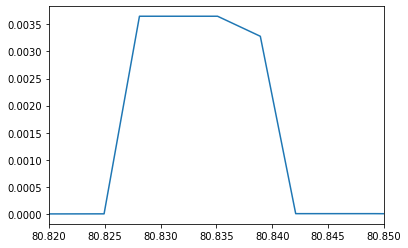

In [ ]:
raw_path = 'los.00' + '{0:03}'.format(0) +'.raw'
distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
plt.plot(distance,HI_density)
plt.xlim(80.82,80.85)

In [ ]:
A[1]

185.56932845796155

In [ ]:
#define T, J_HI
#find all the delta b plus under the two bases, calculate the second derivative
# the delta b plus is just the delta b plus at the peak of the curve
J_HI =1.601e-20

In [ ]:
len(temperature)

2

In [ ]:
N_HI = 1.63e13*(np.divide(temperature,10**4))**-0.7*((0.0479*(0.6814**2))/0.0125)**2*(J_HI/0.5)**-1*(((1+5.88)/4)**5)*(2/1.65)**-0.5*A

In [ ]:
N_HI

array([1.03688082e+36, 3.76525535e+36])

In [ ]:
real_area_under

[5.23607944285154e+17, 3.2870950817011233e+19]

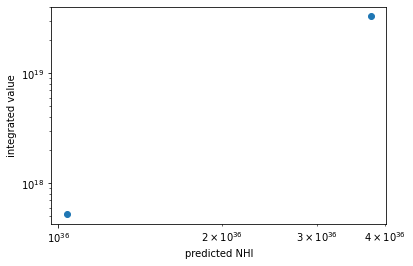

In [ ]:
plt.scatter(N_HI,real_area_under)
plt.xlabel("predicted NHI")
plt.ylabel("integrated value")
plt.xscale("log")
plt.yscale("log")